## Environment

In [1]:
# install the modules
# !pip install pennylane
# # !pip install aiohttp fsspec h5py
# !pip install pennylane-lightning

# import data processing
import pennylane as qml
from pennylane import qchem
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Callable
import time
import os
import logging
from utill import QKLSTM
# silence!
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 僅顯示錯誤，忽略警告

## Set Param.

In [2]:
# hyperparam
## LSTM
### opt for LSTM train: Adam
lr_lstm = 0.1
fixed_param_dim = 20
epochs = 5
steps_per_epoch = 5
max_steps_per_epoch = 15
min_steps_per_epoch = 5
max_mean_loss = 1e-2
min_mean_loss = 1e-3
conv_tol_lstm = 1e-5
LossFunction = "weighted"
steps_recurrent_loop_for_test = 10 # for test
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## VQE for test
lr_vqe = 0.1
mix_iter_vqe = 500
conv_tol_vqe = 1e-6
## optimizer for vqe test: Adam or SGD

# param
## initial_method of params for traditional vqe: Zeros, Pi, Random
molecule = [
    ("H2", [0.5]),
    ("H2", [0.54]),
    ("H2", [0.58]),
    ("H2", [0.62]),
    ("H2", [0.66]),
    ("H2", [0.82]),
    ("H2", [0.86]),
    ("H2", [0.9]),
    ("H2", [0.94]),
    ("H2", [0.98]),
    ("H2", [1.02]),
    ("H2", [1.06]),
    ("H2", [1.1]),
    ("H2", [1.14]),
    ("H2", [1.18]),
    ("H2", [1.22]),
    ("H2", [1.26]),
    ("H2", [1.3]),
    ("H2", [1.34]),
    ("H2", [1.38]),
    ("H2", [1.42]),
    ("H2", [1.46]),
    ("H2", [1.5]),
    ("H2", [1.54]),
    ("H2", [1.58]),
    ("H2", [1.62]),
    ("H2", [1.66]),
    ("H2", [1.7]),
    ("H2", [1.74]),
    ("H2", [1.78]),
    ("H2", [1.82]),
    ("H2", [1.86]),
    ("H2", [1.9]),
    ("H2", [1.94]),
    ("H2", [1.98]),
    ("H2", [2.02]),
    ("H2", [2.06]),
    ("H2", [2.1]),
    ("H3+", [0.5]),
    ("H3+", [0.54]),
    ("H3+", [0.58]),
    ("H3+", [0.62]),
    ("H3+", [0.66]),
    ("H3+", [0.7]),
    ("H3+", [0.74]),
    ("H3+", [0.78]),
    ("H3+", [0.82]),
    ("H3+", [0.86]),
    ("H3+", [0.9]),
    ("H3+", [0.94]),
    ("H3+", [0.98]),
    ("H3+", [1.02]),
    ("H3+", [1.06]),
    ("H3+", [1.1]),
    ("H3+", [1.14]),
    ("H3+", [1.18]),
    ("H3+", [1.22]),
    ("H3+", [1.26]),
    ("H3+", [1.3]),
    ("H3+", [1.34]),
    ("H3+", [1.38]),
    ("H3+", [1.42]),
    ("H3+", [1.46]),
    ("H3+", [1.5]),
    ("H3+", [1.54]),
    ("H3+", [0.5]),
    ("H2", None),
    ("H3+", None),
    ("H4", None)

]

## Models

In [3]:
class QLSTM(nn.Module):
  def __init__(self, fixed_param_dim, max_s_params, max_d_params):
    super().__init__()
    self.fixed_param_dim = fixed_param_dim
    self.single_mapping = nn.Linear(fixed_param_dim//2, max_s_params, bias = False)
    self.double_mapping = nn.Linear(fixed_param_dim//2, max_d_params, bias = False)
    self.lstm_cell = QKLSTM(input_size = 1 +fixed_param_dim, hidden_size = fixed_param_dim, batch_first=True,
                    n_qubits = 4,
                    n_qlayers= 1,
                    return_sequences=False
        )

  def forward(self, inputs):
    prev_cost, prev_params, prev_h, prev_c = inputs

    device = self.lstm_cell.clayer_in.weight.device

    # 如果某些變數是 tuple，拆出來
    if isinstance(prev_h, tuple):
        prev_h = prev_h[0]
    if isinstance(prev_c, tuple):
        prev_c = prev_c[0]

    prev_cost = prev_cost.to(device)
    prev_params = prev_params.to(device)
    prev_h = prev_h.to(device)
    prev_c = prev_c.to(device)

    new_input = torch.cat([prev_cost, prev_params], dim=-1)
    new_h, new_c = self.lstm_cell(new_input, (prev_h, prev_c))

    return prev_params, new_h, new_c


  def recurrent_loop(self, molecule_cost, steps = 5, LossFunction = "weighted", intermediate_steps=False):
    initial_cost = torch.zeros(size=(1, 1), dtype=torch.float64)
    initial_params = torch.zeros(size=(1, self.fixed_param_dim), dtype=torch.float64, requires_grad= True)
    initial_h = torch.zeros(size=(1, self.fixed_param_dim), dtype=torch.float64)
    initial_c = torch.zeros(size=(1, self.fixed_param_dim), dtype=torch.float64)

    initial_h.requires_grad_(False)
    initial_c.requires_grad_(False)

    current_inputs = [initial_cost, initial_params, initial_h, initial_c]
    param_outputs = []
    cost_outputs = []

    for _ in range(steps):
      new_params, new_h, new_c = self.forward(current_inputs)
      _cost = molecule_cost(new_params)
      new_cost = _cost.to(dtype = torch.float32).reshape(1,1)

      current_inputs = [new_cost, new_params, new_h, new_c]
      param_outputs.append(new_params)
      cost_outputs.append(new_cost)

    if LossFunction == "weighted":

      loss = 0.0

      for t in range(len(cost_outputs)):
        coeff = 0.1*(t+1)
        loss += cost_outputs[t]*coeff
      loss = loss/len(cost_outputs)

    elif LossFunction == "descent":
      if len(cost_outputs)>0:
        min_cost_sofar = cost_outputs[0]
        for t in range(1,len(cost_outputs)):
          min = torch.min(torch.stack(cost_outputs[:t]))
          loss+=cost_outputs[t]-min

    if intermediate_steps:
        return [p.detach() for p in param_outputs] + [loss]
    else:
        return loss


def train_step(model, molecule_cost, optimizer, LossFunction = "weighted", steps = 10):
  optimizer.zero_grad()
  loss = model.recurrent_loop(molecule_cost = molecule_cost, steps = steps, LossFunction = LossFunction)
  loss.backward()
  optimizer.step()

  return loss

In [4]:
def vqe_molecule(data,max_qubits, single_mapping_layer, double_mapping_layer, fixed_param_dim):

  # Number of qubits (wires) equal to the max qubits
  wires = range(max_qubits)
  # Number of qubits (wires) equal to the number of qubits required for the HF state
  orbitals = len(data.hf_state)
  # the number of electrons and molecules
  electrons = sum(data.hf_state)
  # the wires of single and double excitations
  single_exciations, double_exciations = qchem.excitations(electrons,orbitals)

  s_wires, d_wires = qml.qchem.excitations_to_wires(single_exciations, double_exciations)

  num_single = len(s_wires)
  num_double = len(d_wires)
  #print(num_single)
  #print(num_double)
  single_mapping_layer = single_mapping_layer.to(dtype=torch.float64)
  double_mapping_layer = double_mapping_layer.to(dtype=torch.float64)
  # Create the actual quantum circuit for the VQE algorithm
  def circuit(params, wires):

    # the params for single and double excitations
    params = params.reshape(-1)
    half_dim = fixed_param_dim // 2
    single_input = params[:half_dim]
    double_input = params[half_dim:]
    #print(single_input)
    #print(double_input)
    #put in the cuda
    device = single_mapping_layer.weight.device
    single_input = single_input.to(device).to(dtype=torch.float64)
    double_input = double_input.to(device).to(dtype=torch.float64)

    single_params_full = single_mapping_layer(single_input.unsqueeze(0)).squeeze(0)
    double_params_full = double_mapping_layer(double_input.unsqueeze(0)).squeeze(0)
    #print(single_params_full)
    #print(double_params_full)
    single_params = single_params_full[:num_single]
    double_params = double_params_full[:num_double]
    #print(single_params)
    #print(double_params)
    mapped_params = torch.cat([single_params, double_params], dim=0)
    #print(mapped_params)
    # something we want to train, ansatz
    qml.UCCSD(mapped_params, range(orbitals), s_wires, d_wires, data.hf_state)

    return qml.expval(data.hamiltonian)

  # Evaluates the cost Hamiltonian
  def hamiltonian_cost(params, **kwargs):
    # Define device
    # This qnode evaluates the expectation value of the cost hamiltonian operator
    dev = qml.device("lightning.gpu", wires=wires)
    cost = qml.QNode(circuit, dev, diff_method="adjoint", interface="torch")

    return cost(params, wires = wires)

  return hamiltonian_cost

In [5]:
def vqe_molecule_traditional(data):

  # Number of qubits (wires) equal to the max qubits
  wires = range(len(data.hf_state))
  #print(wires)
  # Number of qubits (wires) equal to the number of qubits required for the HF state
  orbitals = len(data.hf_state)
  # the number of electrons and molecules
  electrons = sum(data.hf_state)
  # the wires of single and double excitations
  single_exciations, double_exciations = qchem.excitations(electrons,orbitals)

  s_wires, d_wires = qml.qchem.excitations_to_wires(single_exciations, double_exciations)
  #print(s_wires)
  #print(d_wires)
  #print(total_params_dim)

  # Create the actual quantum circuit for the VQE algorithm
  def circuit(params, wires):

    # something we want to train, ansatz
    qml.UCCSD(params, range(orbitals), s_wires, d_wires, data.hf_state)

    return qml.expval(data.hamiltonian)

  # Evaluates the cost Hamiltonian
  def hamiltonian_cost(params, **kwargs):
    # Define device
    # This qnode evaluates the expectation value of the cost hamiltonian operator
    dev = qml.device("lightning.gpu", wires=wires)
    cost = qml.QNode(circuit, dev, diff_method="adjoint", interface="torch")

    return cost(params, wires = wires)

  return hamiltonian_cost

In [6]:
def vqe_optimization(molecule_cost, initial_params, max_iter=500, learning_rate=0.1, conv_tol = 1e-6, optimizer = "Adam"):

    params = torch.tensor(initial_params, requires_grad = True, dtype = torch.float64)

    if optimizer == "Adam":
      opt = optim.Adam([params], lr = learning_rate)

    elif optimizer == "SGD":
      opt = optim.SGD([params], lr = learning_rate)

    #
    energy_history = [molecule_cost(params).item()]
    param_history = [params.clone().detach()]
    conv_iter = max_iter

    # optimization loop
    for iteration in range(max_iter):
        opt.zero_grad()
        cost = molecule_cost(params)
        cost.backward()
        opt.step()

        energy_history.append(cost.item())
        param_history.append(params.clone().detach())

        if iteration%50 == 0:
          print(f"Step =  {iteration+1}/{max_iter}, Energy= {energy_history[-1]:.8f} Ha")

        if iteration > 0:
          conv = np.abs(energy_history[-1] - energy_history[-2])
          if conv <= conv_tol:
            conv_iter = iteration + 1
            break

    return conv_iter, param_history[-1], energy_history[-1], param_history, energy_history

## Data Loading and processing

In [7]:
# load data from pennylane
def load_data(molecule, basis="STO-3G"):
  data_list = []

  for mol,bondlengths in molecule:
    # If bondlengths is None, load default bond length
    if bondlengths is None:
      data = qml.data.load("qchem", molname=mol, basis=basis)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    else:
      # Otherwise, iterate over the bond lengths
      data = qml.data.load("qchem", molname=mol, basis=basis, bondlength=bondlengths)
      #print(f"{data[0].molecule},{data[0].bondlength}")

    for entry in data:
      data_list.append(entry)

  df = pd.DataFrame(data_list)
  return df
# HeH2 only has 6-31G, also, C2H6, CO2, N2H4, C2H4, N2H2, CH2O, C2H2 no data

In [8]:
# display the information of molecule
# find the index
def display_data(dataset, molecule_name, attribute = False):

  if attribute is True:
    print("Available attributes in qchem")
    print(qml.data.list_attributes(data_name="qchem"))

  for i in range(len(dataset[0])):
    if dataset[0][i].molname == molecule_name:
      data = dataset[0][i]

      print(f"Index : {i}")
      print(f"Molecule : {data.molecule}")
      print(f"Molecule : {data.basis}"   )
      print(f"HF state : {data.hf_state}")
      print(f"hamiltonian : {data.hamiltonian}")
      print(f"VQE energy : {data.vqe_energy}")
      print(f"VQE gates : {data.vqe_gates}")
      print(f"VQE params : {data.vqe_params}")
      print(f"Bondlength: {data.bondlength}")
      print(f"FCI gates : {data.fci_energy}")

In [9]:
def electrons_and_orbitals(hf_state):
  electrons = sum(hf_state)
  orbitals = int(len(hf_state))

  return electrons, orbitals

In [10]:
def max_params (dataset):
  max_s_wires = 0
  max_d_wires = 0

  for data in dataset:
    electrons, orbitals = electrons_and_orbitals(data.hf_state)

    single, double = qchem.excitations(electrons, orbitals)
    s_w, d_w = qml.qchem.excitations_to_wires(single, double)
    single = len(s_w)
    double = len(d_w)
    max_s_wires = max(max_s_wires, single)
    max_d_wires = max(max_d_wires, double)

  return max_s_wires, max_d_wires

## Download Data and then process

In [11]:
# Load dataset
dataset = load_data(molecule, basis="STO-3G")
print(dataset.head())

                                                   0
0  <Dataset = molname: H2, basis: STO-3G, bondlen...
1  <Dataset = molname: H2, basis: STO-3G, bondlen...
2  <Dataset = molname: H2, basis: STO-3G, bondlen...
3  <Dataset = molname: H2, basis: STO-3G, bondlen...
4  <Dataset = molname: H2, basis: STO-3G, bondlen...


In [12]:
# output the qubits and the number of param. we need
max_qubits = 0

for i in range(len(dataset[0])):
  if len(dataset[0][i].hf_state) > max_qubits:
    max_qubits = len(dataset[0][i].hf_state)

print(max_qubits)

max_s_params, max_d_params = max_params(dataset[0])
print(f"the number of max single wires: {max_s_params}")
print(f"the number of max double wires: {max_d_params}")

8
the number of max single wires: 8
the number of max double wires: 18


In [13]:
# find the index of specific molecule if you need
display_data(dataset = dataset, molecule_name = "H4", attribute = True)

Available attributes in qchem
['basis_rot_groupings', 'basis_rot_samples', 'dipole_op', 'fci_energy', 'fci_spectrum', 'hamiltonian', 'hf_state', 'initial_state_coeffs', 'initial_state_dets', 'molecule', 'number_op', 'optimal_sector', 'paulix_ops', 'qwc_groupings', 'qwc_samples', 'sparse_hamiltonian', 'spin2_op', 'spinz_op', 'symmetries', 'tapered_dipole_op', 'tapered_hamiltonian', 'tapered_hf_state', 'tapered_num_op', 'tapered_spin2_op', 'tapered_spinz_op', 'vqe_energy', 'vqe_gates', 'vqe_params']
Index : 68
Molecule : <Molecule = H4, Charge: 0, Basis: STO-3G, Orbitals: 4, Electrons: 4>
Molecule : STO-3G
HF state : [1 1 1 1 0 0 0 0]
hamiltonian : 0.0077850470101684666 * I(0) + 0.2029572455064479 * Z(0) + 0.202957245506448 * Z(1) + 0.1319392995399748 * (Z(0) @ Z(1)) + -0.004548592840507519 * (Y(0) @ Z(1) @ Z(2) @ Z(3) @ Y(4)) + -0.021657966390520433 * (Y(0) @ Z(2) @ Z(3) @ Y(4)) + -0.004548592840507519 * (X(0) @ Z(1) @ Z(2) @ Z(3) @ X(4)) + -0.021657966390520433 * (X(0) @ Z(2) @ Z(3) @ 

In [14]:
# divide data into train set and test set
dataset_list = list(dataset[0])
train_set = dataset_list[:68]
test_set = dataset_list[68]
print(f"train set: {train_set}")
print(f"test set: {test_set}")

train set: [<Dataset = molname: H2, basis: STO-3G, bondlength: 0.5, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.54, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.58, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.62, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.66, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.82, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.86, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.9, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.94, attributes: ['molname', 'basis', ...]>, <Dataset = molname: H2, basis: STO-3G, bondlength: 0.98, attributes: ['molname', 'basis', ...]>, <Dataset = molname: 

## Train

In [15]:
max_s_params, max_d_params = max_params(dataset[0])
model = QLSTM(fixed_param_dim, max_s_params, max_d_params)
model.to(dtype=torch.float64)
model = model.double()
print(model)

QLSTM(
  (single_mapping): Linear(in_features=10, out_features=8, bias=False)
  (double_mapping): Linear(in_features=10, out_features=18, bias=False)
  (lstm_cell): QKLSTM(
    (clayer_in): Linear(in_features=41, out_features=4, bias=True)
    (clayer_out): Linear(in_features=4, out_features=20, bias=True)
  )
)


In [16]:
molecule_cost_list = [vqe_molecule(m,
                                   max_qubits = max_qubits,
                                   single_mapping_layer = model.single_mapping,
                                   double_mapping_layer=model.double_mapping,
                                   fixed_param_dim=fixed_param_dim) for m in train_set]

In [17]:
opt = optim.Adam(model.parameters(), lr = lr_lstm)

previous_mean_loss = None

print("---Train--")
for epoch in range(epochs):
  start_time = time.time()

  if epoch%10 == 0:
    print(f"\nEpoch {epoch+1}/{epochs}")

  epoch_loss = []
  for i, molecule_cost in enumerate(molecule_cost_list):
    loss = train_step(model, molecule_cost, opt, LossFunction= LossFunction, steps = steps_per_epoch)
    epoch_loss.append(loss.item())

    if (i+1)%10 == 0:
      print(f" > Molecule ({i+1}/{len(molecule_cost_list)}) - Loss: {loss.item():.8f}")
      print(f" > steps_per_epoch: {steps_per_epoch}")

  epoch_loss = np.array(epoch_loss)
  mean_loss = np.mean(epoch_loss)

  if epoch%10 == 0:
    print(f" > Mean loss: {mean_loss:.6f}")

  # if mean_loss > max_mean_loss:
  #   steps_per_epoch = min(steps_per_epoch + 2, max_steps_per_epoch)
  # elif mean_loss < min_mean_loss:
  #   steps_per_epoch = max(steps_per_epoch - 2, min_steps_per_epoch)

  # if previous_mean_loss is not None:
  #   rel_change = abs(previous_mean_loss - mean_loss) / abs(previous_mean_loss)
  #   if rel_change < conv_tol_lstm:
  #     print(f"Training Converged at Epoch {epoch+1}")
  #     break

    # 更新前一個平均損失
  previous_mean_loss = mean_loss

  end_time = time.time()
  execution_time = end_time - start_time

  print(f"Execution time of train for {epoch+1}: {execution_time:.1f} seconds")

---Train--

Epoch 1/5
 > Molecule (10/68) - Loss: -0.32149401
 > steps_per_epoch: 5


 > Molecule (20/68) - Loss: -0.28432244
 > steps_per_epoch: 5
 > Molecule (30/68) - Loss: -0.25013646
 > steps_per_epoch: 5
 > Molecule (40/68) - Loss: -0.25644302
 > steps_per_epoch: 5
 > Molecule (50/68) - Loss: -0.37385225
 > steps_per_epoch: 5
 > Molecule (60/68) - Loss: -0.35109019
 > steps_per_epoch: 5
 > Mean loss: -0.309390
Execution time of train for 1: 103.8 seconds
 > Molecule (10/68) - Loss: -0.32149401
 > steps_per_epoch: 5
 > Molecule (20/68) - Loss: -0.28432244
 > steps_per_epoch: 5
 > Molecule (30/68) - Loss: -0.25013646
 > steps_per_epoch: 5
 > Molecule (40/68) - Loss: -0.25644302
 > steps_per_epoch: 5
 > Molecule (50/68) - Loss: -0.37385225
 > steps_per_epoch: 5
 > Molecule (60/68) - Loss: -0.35109019
 > steps_per_epoch: 5
Execution time of train for 2: 102.5 seconds
 > Molecule (10/68) - Loss: -0.32149401
 > steps_per_epoch: 5
 > Molecule (20/68) - Loss: -0.28432244
 > steps_per_epoch: 5
 > Molecule (30/68) - Loss: -0.25013646
 > steps_per_epoch: 5
 > Molecule (40/68

In [18]:
# Save the model
torch.save(model.state_dict(), "qlstm_vqe1.pth")

In [19]:
# load model if need
model = QLSTM(fixed_param_dim, max_s_params, max_d_params)
model.load_state_dict(torch.load("qlstm_vqe1.pth"))

<All keys matched successfully>

## Test

In [20]:
test_molecule_cost = vqe_molecule(test_set,
                                  max_qubits = max_qubits,
                                  single_mapping_layer = model.single_mapping,
                                  double_mapping_layer = model.double_mapping,
                                  fixed_param_dim = fixed_param_dim)

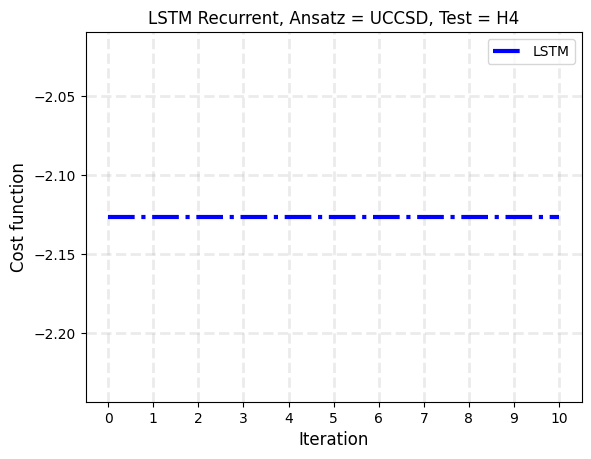

In [21]:
with torch.no_grad():
  res = model.recurrent_loop(
      test_molecule_cost,
      steps = steps_recurrent_loop_for_test,
      LossFunction = LossFunction,
      intermediate_steps = True
  )

initial_zero_guess = torch.zeros(fixed_param_dim, dtype=torch.float64)

guesses = [initial_zero_guess] + [
    r.squeeze(0) for r in res[:-1]
]

final_loss = res[-1]

lstm_loss = [
    test_molecule_cost(guess.unsqueeze(0)).item()
    for guess in guesses
]

fig, ax = plt.subplots()

plt.plot(lstm_loss, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.title("LSTM Recurrent, Ansatz = UCCSD, Test = H4")
plt.legend()
#ax.set_xticks([0, 5, 10, 15, 20])
ax.set_xticks(range(0, len(lstm_loss)))
plt.show()

In [22]:
conv_iter_adam_lstm, lstm_optimized_params_adam_lstm, lstm_optimized_energy_adam_lstm, lstm_param_history_adam_lstm, lstm_energy_history_adam_lstm = vqe_optimization(
    test_molecule_cost,
    initial_params=guesses[-1],
    max_iter=mix_iter_vqe,
    learning_rate=lr_vqe,
    conv_tol = conv_tol_vqe,
    optimizer = "Adam"
)

/tmp/ipykernel_2642851/3533223302.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad = True, dtype = torch.float64)


Step =  1/500, Energy= -2.12646842 Ha


Step =  51/500, Energy= -2.16060996 Ha


Test for traditional VQE

In [23]:
def initial_params_test(data, initial_method):
# Number of qubits (wires) equal to the max qubits
  wires = range(len(data.hf_state))
  #print(wires)
  # Number of qubits (wires) equal to the number of qubits required for the HF state
  orbitals = len(data.hf_state)
  # the number of electrons and molecules
  electrons = sum(data.hf_state)
  # the wires of single and double excitations
  single_exciations, double_exciations = qchem.excitations(electrons,orbitals)

  s_wires, d_wires = qml.qchem.excitations_to_wires(single_exciations, double_exciations)
  #print(s_wires)
  #print(d_wires)
  total_params_dim = len(d_wires) + len(s_wires)
  #print(total_params_dim)
  if initial_method == "Zeros":
    return torch.zeros(total_params_dim, requires_grad=True, dtype = torch.float64)
    #print(params)
  elif initial_method == "Random":
    return torch.rand(total_params_dim, requires_grad=True, dtype = torch.float64)
  elif initial_method == "Pi":
    return torch.full((total_params_dim,), torch.pi, requires_grad=True, dtype = torch.float64)

In [24]:
## initial_method: Zeros
test_molecule_traditional_0  = vqe_molecule_traditional(test_set)

conv_iter_0_adam_traditional, vqe_optimized_params_0_adam_traditional, vqe_optimized_energy_0_adam_traditional, vqe_param_history_0_adam_traditional, vqe_energy_history_0_adam_traditional = vqe_optimization(
    test_molecule_traditional_0,
    initial_params=initial_params_test(test_set,"Zeros"),
    max_iter=mix_iter_vqe,
    learning_rate=lr_vqe,
    conv_tol = conv_tol_vqe,
    optimizer = "Adam"
)

## initial_method: Random
test_molecule_traditional_random = vqe_molecule_traditional(test_set)

conv_iter_random_adam_traditional, vqe_optimized_params_random_adam_traditional, vqe_optimized_energy_random_adam_traditional, vqe_param_history_random_adam_traditional, vqe_energy_history_random_adam_traditional = vqe_optimization(
    test_molecule_traditional_random,
    initial_params= initial_params_test(test_set,"Random"),
    max_iter=mix_iter_vqe,
    learning_rate=lr_vqe,
    conv_tol = conv_tol_vqe,
    optimizer = "Adam"
)

## initial_method:  Pi
test_molecule_traditional_pi = vqe_molecule_traditional(test_set)

conv_iter_pi_adam_traditional, vqe_optimized_params_pi_adam_traditional, vqe_optimized_energy_pi_adam_traditional, vqe_param_history_pi_adam_traditional, vqe_energy_history_pi_adam_traditional = vqe_optimization(
    test_molecule_traditional_pi,
    initial_params=initial_params_test(test_set,"Pi"),
    max_iter=mix_iter_vqe,
    learning_rate=lr_vqe,
    conv_tol = conv_tol_vqe,
    optimizer = "Adam"
)

/tmp/ipykernel_2642851/3533223302.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad = True, dtype = torch.float64)


Step =  1/500, Energy= -2.12646842 Ha


Step =  51/500, Energy= -2.18015790 Ha


/tmp/ipykernel_2642851/3533223302.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad = True, dtype = torch.float64)


Step =  1/500, Energy= -0.30278352 Ha
Step =  51/500, Energy= -2.17433429 Ha


/tmp/ipykernel_2642851/3533223302.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  params = torch.tensor(initial_params, requires_grad = True, dtype = torch.float64)


Step =  1/500, Energy= -2.12646842 Ha
Step =  51/500, Energy= -2.16304159 Ha
Step =  101/500, Energy= -2.17997003 Ha


## Save data

In [25]:
import csv

data = {
    'lstm_loss': pd.Series(lstm_loss),
    'lstm_energy_history_adam_lstm': pd.Series(lstm_energy_history_adam_lstm),
    'vqe_energy_history_0_adam_traditional': pd.Series(vqe_energy_history_0_adam_traditional),
    'vqe_energy_history_random_adam_traditional': pd.Series(vqe_energy_history_random_adam_traditional),
    'vqe_energy_history_pi_adam_traditional': pd.Series(vqe_energy_history_pi_adam_traditional),
}

df = pd.DataFrame(data)
df.to_csv('LSTM-VQE-FC UCCSD result for Fixed 20 weighted loss.csv', index=False)

## Result

In [26]:
print("=== Comparison of VQE Optimization ===")
print("Real data")
print(f"  Molecule: {test_set.molecule}")
print(f"  VQE energy: {test_set.vqe_energy}")
print(f"  FCI energy: {test_set.fci_energy}")
print(f"  erros(%):{abs((test_set.vqe_energy-test_set.fci_energy)/test_set.fci_energy*100)}%")

print("VQE Zeros ADAM")
error_vqe_0_adam = vqe_optimized_energy_0_adam_traditional - test_set.fci_energy
print(f"  Iter: {conv_iter_0_adam_traditional}")
print(f"  Final Energy: {vqe_optimized_energy_0_adam_traditional}")
print(f"  error:{error_vqe_0_adam}")
print(f"  error(%): {abs(error_vqe_0_adam/test_set.fci_energy*100)}%")

print("VQE Random ADAM")
error_vqe_random_adam = vqe_optimized_energy_random_adam_traditional - test_set.fci_energy
print(f"  Iter: {conv_iter_random_adam_traditional}")
print(f"  Final Energy: {vqe_optimized_energy_random_adam_traditional}")
print(f"  error:{error_vqe_random_adam}")
print(f"  error(%): {abs(error_vqe_random_adam/test_set.fci_energy*100)}%")

print("VQE Pi ADAM")
error_vqe_pi_adam = vqe_optimized_energy_pi_adam_traditional - test_set.fci_energy
print(f"  Iter: {conv_iter_pi_adam_traditional}")
print(f"  Final Energy: {vqe_optimized_energy_pi_adam_traditional}")
print(f"  error:{error_vqe_pi_adam}")
print(f"  error(%): {abs(error_vqe_pi_adam/test_set.fci_energy*100)}%")

print("LSTM-FC-VQE")
error_vqe_lstm_adam = lstm_optimized_energy_adam_lstm - test_set.fci_energy
print(f"  Iter: {conv_iter_adam_lstm}")
print(f"  Final Energy: {lstm_optimized_energy_adam_lstm}")
print(f"  error:{error_vqe_lstm_adam}")
print(f"  error(%): {abs(error_vqe_lstm_adam/test_set.fci_energy*100)}%")

=== Comparison of VQE Optimization ===
Real data
  Molecule: <Molecule = H4, Charge: 0, Basis: STO-3G, Orbitals: 4, Electrons: 4>
  VQE energy: -2.1801341057956214
  FCI energy: -2.180410213096908
  erros(%):0.012663089707982127%
VQE Zeros ADAM
  Iter: 62
  Final Energy: -2.1803314685821533
  error:7.874451475453625e-05
  error(%): 0.003611454132875889%
VQE Random ADAM
  Iter: 86
  Final Energy: -2.1802420616149902
  error:0.0001681514819176222
  error(%): 0.007711919569427771%
VQE Pi ADAM
  Iter: 106
  Final Energy: -2.180122137069702
  error:0.00028807602720570813
  error(%): 0.013212010541656027%
LSTM-FC-VQE
  Iter: 51
  Final Energy: -2.1606099605560303
  error:0.019800252540877583
  error(%): 0.9080975874147387%


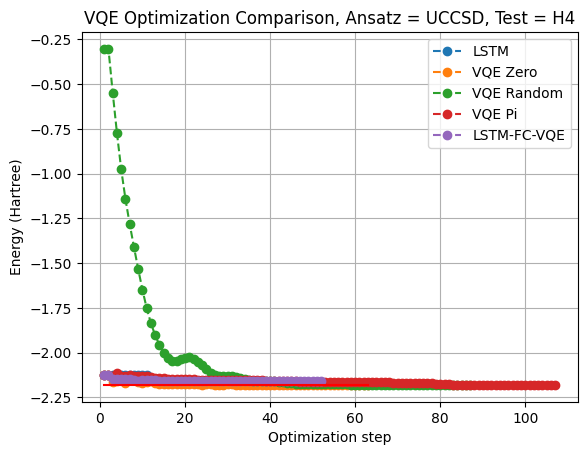

In [27]:
E_fci = test_set.fci_energy
#plt.figure(figsize = (20,10))
plt.plot(range(1, len(lstm_loss) + 1), lstm_loss, marker='o', label='LSTM', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_adam_traditional) + 1), vqe_energy_history_0_adam_traditional, marker='o', label='VQE Zero', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_random_adam_traditional) + 1), vqe_energy_history_random_adam_traditional, marker='o', label='VQE Random', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_pi_adam_traditional) + 1), vqe_energy_history_pi_adam_traditional, marker='o', label='VQE Pi', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_adam_lstm) + 1), lstm_energy_history_adam_lstm, marker='o', label='LSTM-FC-VQE', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_adam_traditional) + 1), np.full(len(vqe_energy_history_0_adam_traditional) , E_fci), color="red")
plt.xlabel("Optimization step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Optimization Comparison, Ansatz = UCCSD, Test = H4")
plt.legend()
plt.grid(True)
plt.show()

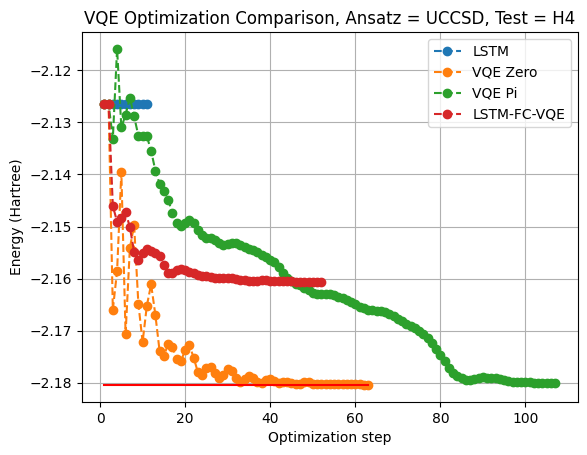

In [28]:
E_fci = test_set.fci_energy
#plt.figure(figsize = (20,10))
plt.plot(range(1, len(lstm_loss) + 1), lstm_loss, marker='o', label='LSTM', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_adam_traditional) + 1), vqe_energy_history_0_adam_traditional, marker='o', label='VQE Zero', ls="dashed")
#plt.plot(range(1, len(vqe_energy_history_random_adam_traditional) + 1), vqe_energy_history_random_adam_traditional, marker='o', label='VQE Random', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_pi_adam_traditional) + 1), vqe_energy_history_pi_adam_traditional, marker='o', label='VQE Pi', ls="dashed")
plt.plot(range(1, len(lstm_energy_history_adam_lstm) + 1), lstm_energy_history_adam_lstm, marker='o', label='LSTM-FC-VQE', ls="dashed")
plt.plot(range(1, len(vqe_energy_history_0_adam_traditional) + 1), np.full(len(vqe_energy_history_0_adam_traditional) , E_fci), color="red")
plt.xlabel("Optimization step")
plt.ylabel("Energy (Hartree)")
plt.title("VQE Optimization Comparison, Ansatz = UCCSD, Test = H4")
plt.legend()
plt.grid(True)
plt.show()